# Predicting gene counts from cell_type and micro-environment

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy 
import matplotlib.pyplot as plt
import seaborn
import pandas
import scanpy as sc
import anndata

from tissue_purifier.model_utils.gene_regression import (
    generate_fake_data, 
    make_gene_dataset_from_anndata,
    GeneDataset, 
    GeneRegression,
    train_test_val_split,
    plot_few_gene_hist
)

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.8.2 anndata==0.7.6 umap==0.5.1 numpy==1.19.2 scipy==1.6.2 pandas==1.3.4 scikit-learn==0.24.1 statsmodels==0.12.2 python-igraph==0.9.0 leidenalg==0.8.3 pynndescent==0.5.2


# Data preparation

Load annotated data from disk

In [3]:
adata = anndata.read_h5ad(filename="adata_0.h5ad")

Add cell and gene id (for scatter plots). Annotate mitocondria.

In [4]:
adata.obs["cell_id"] = numpy.arange(adata.shape[0])
adata.var["gene_id"] = numpy.arange(adata.shape[1])

cell_types = adata.obs["cell_type"]
unique_cell_types = numpy.unique(cell_types)
dict_cell_to_index = dict(zip(unique_cell_types, numpy.arange(len(unique_cell_types))))
cell_types_codes = numpy.array([dict_cell_to_index[cell] for cell in cell_types])
adata.obs["cell_type_codes"] = cell_types_codes

print(adata.var_names)
adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

Index(['0610005C13Rik', '0610007P14Rik', '0610009B22Rik', '0610009E02Rik',
       '0610009L18Rik', '0610009O20Rik', '0610010F05Rik', '0610010K14Rik',
       '0610011F06Rik', '0610012D04Rik',
       ...
       'mt-Tm', 'mt-Tp', 'mt-Tq', 'mt-Ts2', 'mt-Tt', 'mt-Tv', 'n-R5-8s1',
       'n-R5s40', 'n-R5s58', 'n-R5s96'],
      dtype='object', length=24450)


In [5]:
adata

AnnData object with n_obs × n_vars = 31659 × 24450
    obs: 'x', 'y', 'cell_type', 'regress_moran_closest', 'cell_id', 'cell_type_codes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_id', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    obsm: 'feature_barlow_closest', 'feature_cell_number_closest', 'feature_composition_closest'

### Distribution over genes

cell by gene -> (31659, 24450)
-----------------------------
count     24450.000000
mean        999.263067
std        7619.313888
min           0.000000
25%           9.000000
50%          91.000000
75%         538.000000
max      979274.000000
Name: total_counts, dtype: float64
-----------------------------
count    24450.000000
mean       734.262658
std       1916.986501
min          0.000000
25%          9.000000
50%         90.000000
75%        526.750000
max      30569.000000
Name: n_cells_by_counts, dtype: float64
-----------------------------
count    24450.000000
mean        97.680714
std          6.055108
min          3.442939
25%         98.336176
50%         99.715721
75%         99.971572
max        100.000000
Name: pct_dropout_by_counts, dtype: float64


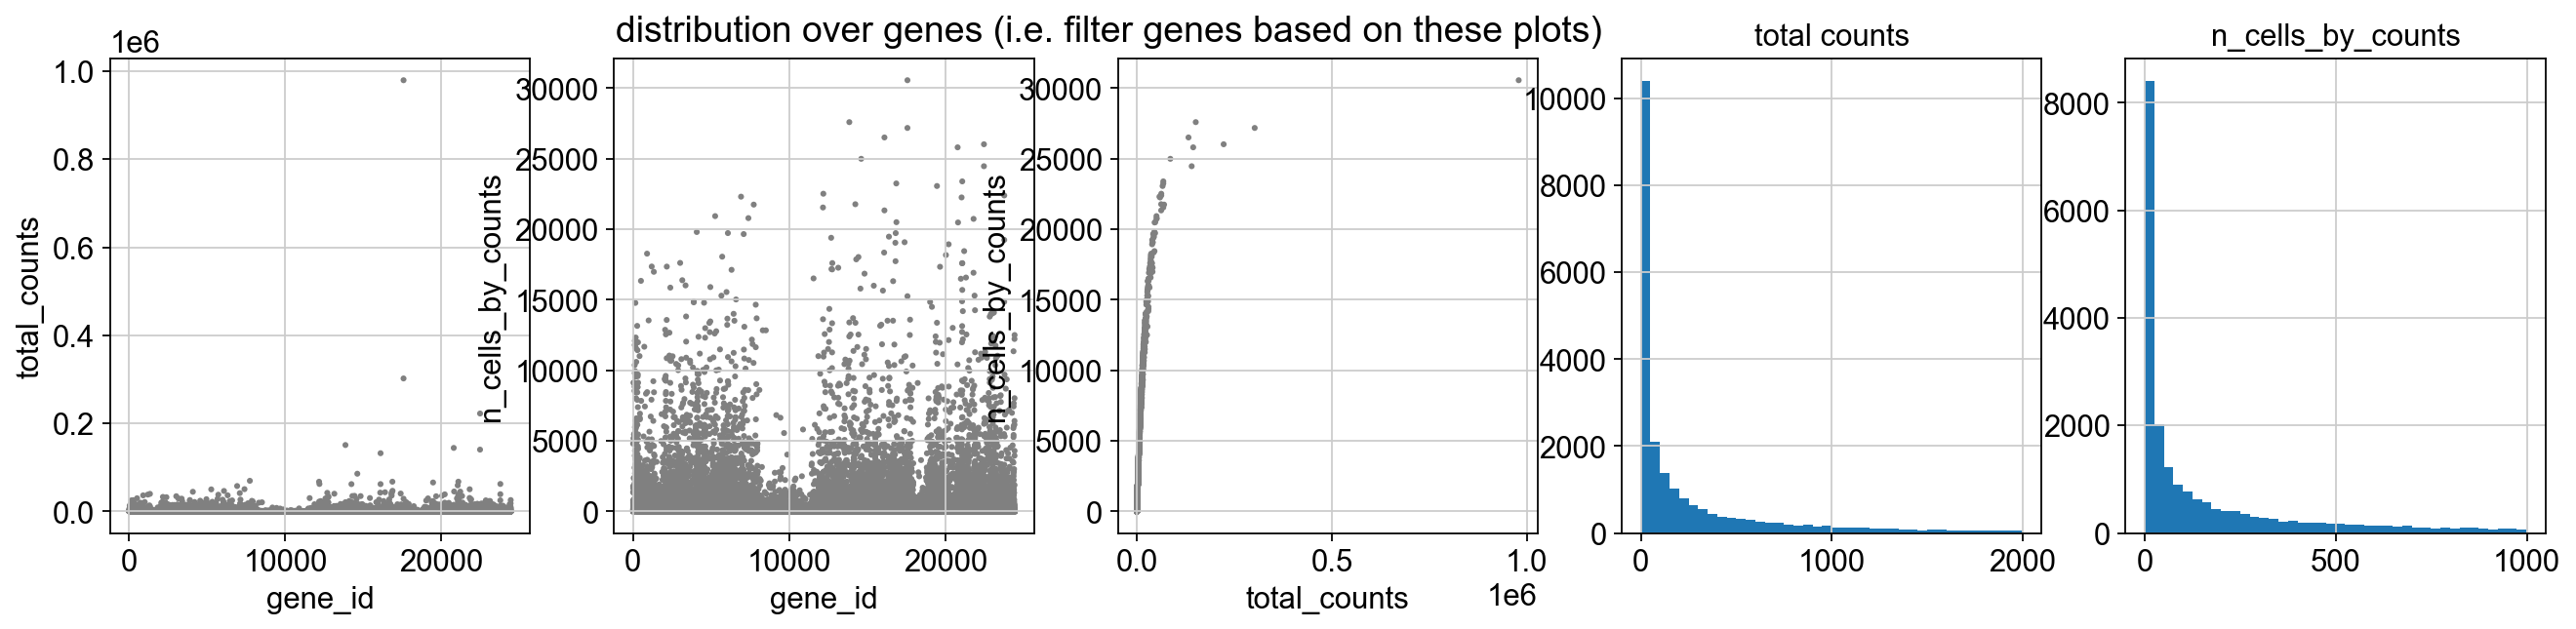

In [6]:
print("cell by gene ->", adata.X.shape)
print("-----------------------------")
print(adata.var['total_counts'].describe())  # the 25% percentile is a good place to filter
print("-----------------------------")
print(adata.var['n_cells_by_counts'].describe())  # the 25% percentile is a good place to filter
print("-----------------------------")
print(adata.var['pct_dropout_by_counts'].describe())

fig, axes = plt.subplots(ncols=5, figsize=(20,4))
fig.suptitle("distribution over genes (i.e. filter genes based on these plots)")
sc.pl.scatter(adata, x='gene_id', y='total_counts', ax=axes[0], size=30, show=False)
sc.pl.scatter(adata, x='gene_id', y='n_cells_by_counts', ax=axes[1], size=30, show=False)
_ = sc.pl.scatter(adata, x='total_counts', y='n_cells_by_counts', ax=axes[2], size=30, show=False)
_ = axes[3].hist(adata.var["total_counts"][adata.var["total_counts"] < 2000], bins=40)
_ = axes[3].set_title("total counts")
_ = axes[4].hist(adata.var["n_cells_by_counts"][adata.var["n_cells_by_counts"] < 1000], bins=40)
_ = axes[4].set_title("n_cells_by_counts")

### Distribution over cells

cell by gene -> (31659, 24450)
-----------------------------
count    31659.000000
mean       771.723112
std        563.300541
min         20.000000
25%        359.000000
50%        668.000000
75%       1067.000000
max       5973.000000
Name: total_counts, dtype: float64
-----------------------------
count    31659.000000
mean       567.065353
std        347.285842
min         14.000000
25%        306.000000
50%        534.000000
75%        786.000000
max       2980.000000
Name: n_genes_by_counts, dtype: float64


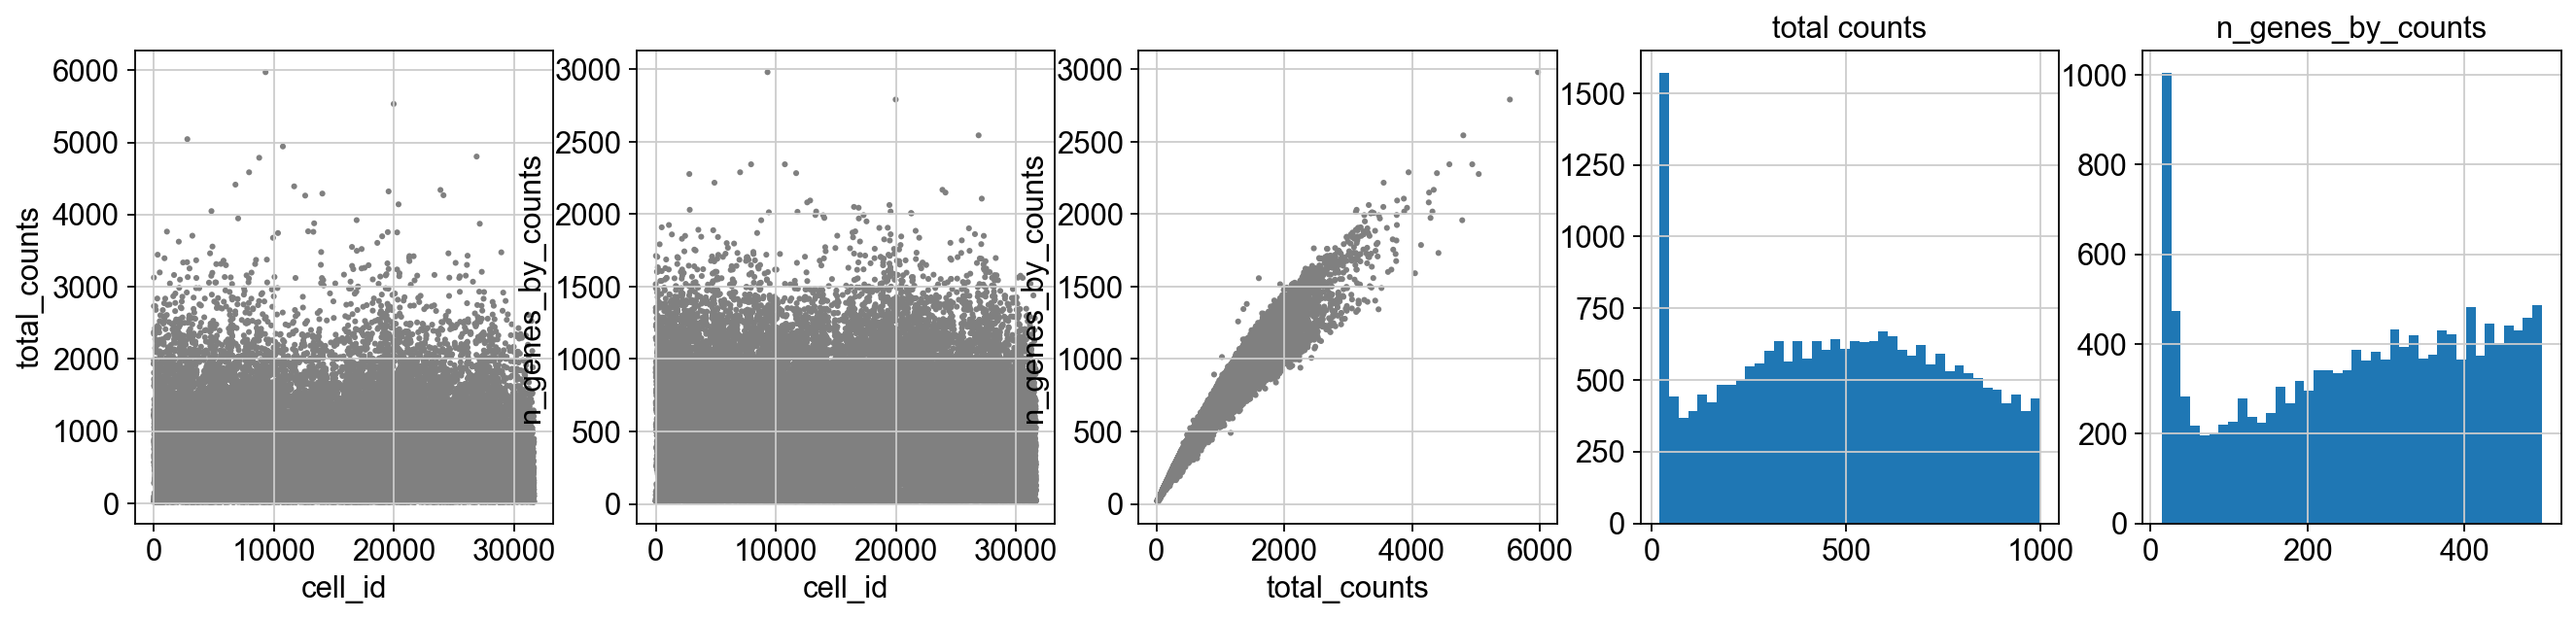

In [7]:
print("cell by gene ->", adata.X.shape)
print("-----------------------------")
print(adata.obs['total_counts'].describe())  # the 25% percentile is a good place to filter
print("-----------------------------")
print(adata.obs['n_genes_by_counts'].describe())  # the 25% percentile is a good place to filter

fig, axes = plt.subplots(ncols=5, figsize=(20,4))
sc.pl.scatter(adata, x='cell_id', y='total_counts', size=30, show=False, ax=axes[0])
sc.pl.scatter(adata, x='cell_id', y='n_genes_by_counts', size=30, show=False, ax=axes[1])
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', size=30, show=False, ax=axes[2])
_ = axes[3].hist(adata.obs["total_counts"][adata.obs["total_counts"] < 1000], bins=40)
_ = axes[3].set_title("total counts")
_ = axes[4].hist(adata.obs["n_genes_by_counts"][adata.obs["n_genes_by_counts"] < 500], bins=40)
_ = axes[4].set_title("n_genes_by_counts")

### Most gene are not present in all cells

count    24450.000000
mean        97.680714
std          6.055108
min          3.442939
25%         98.336176
50%         99.715721
75%         99.971572
max        100.000000
Name: pct_dropout_by_counts, dtype: float64


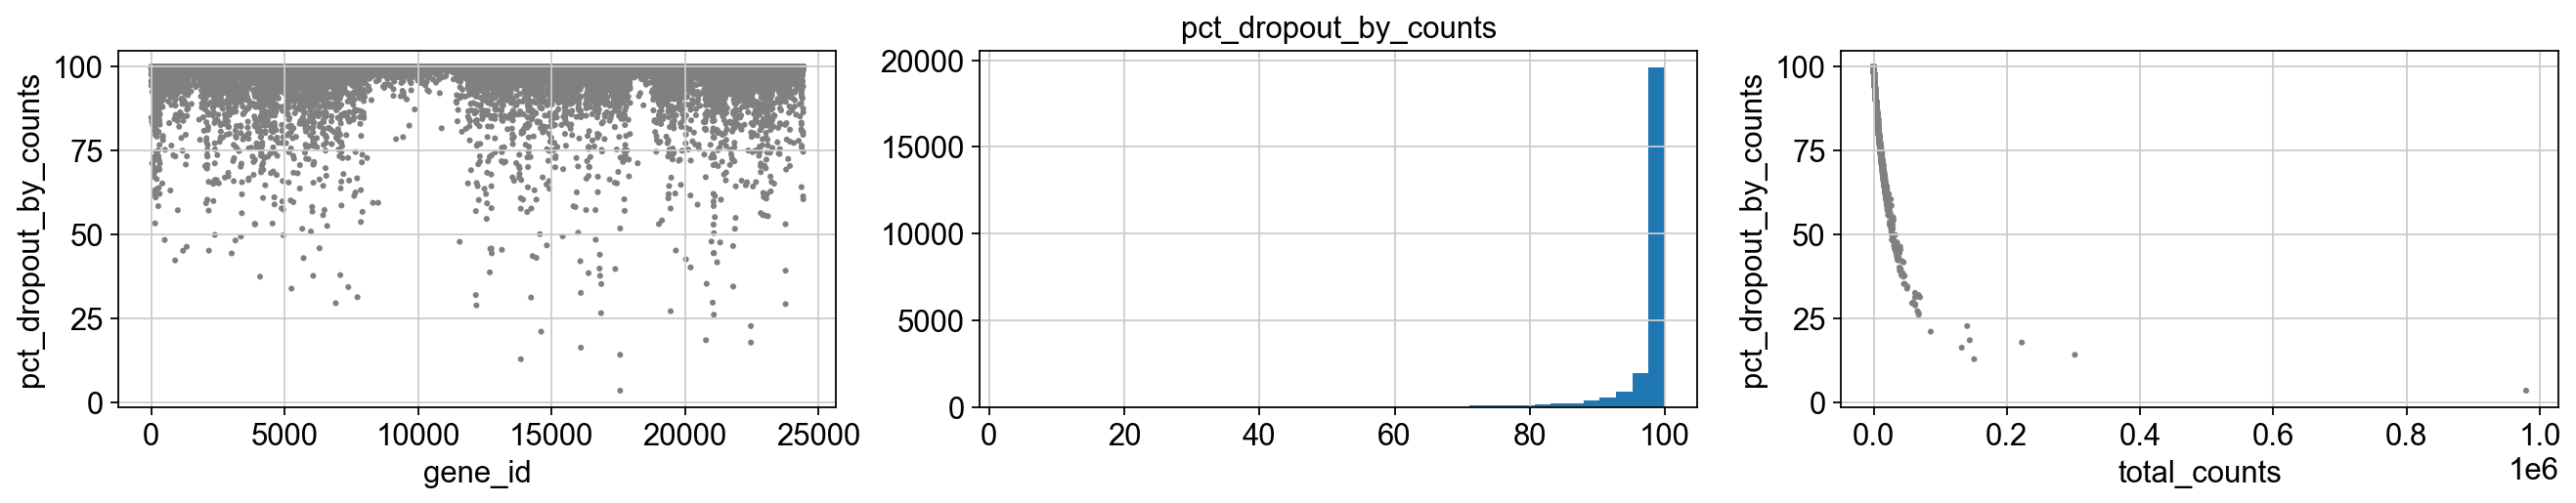

In [8]:
# there are almost no genes that are present in all the cells
print(adata.var['pct_dropout_by_counts'].describe())

fig, axes = plt.subplots(ncols=3, figsize=(20,3))
_ = sc.pl.scatter(adata, x='gene_id', y='pct_dropout_by_counts', ax=axes[0], size=30, show=False)
_ = axes[1].hist(adata.var["pct_dropout_by_counts"], bins=40)
_ = axes[1].set_title("pct_dropout_by_counts")
_ = sc.pl.scatter(adata, x='total_counts', y='pct_dropout_by_counts', ax=axes[2], size=30, show=False)

### Mitocondria check

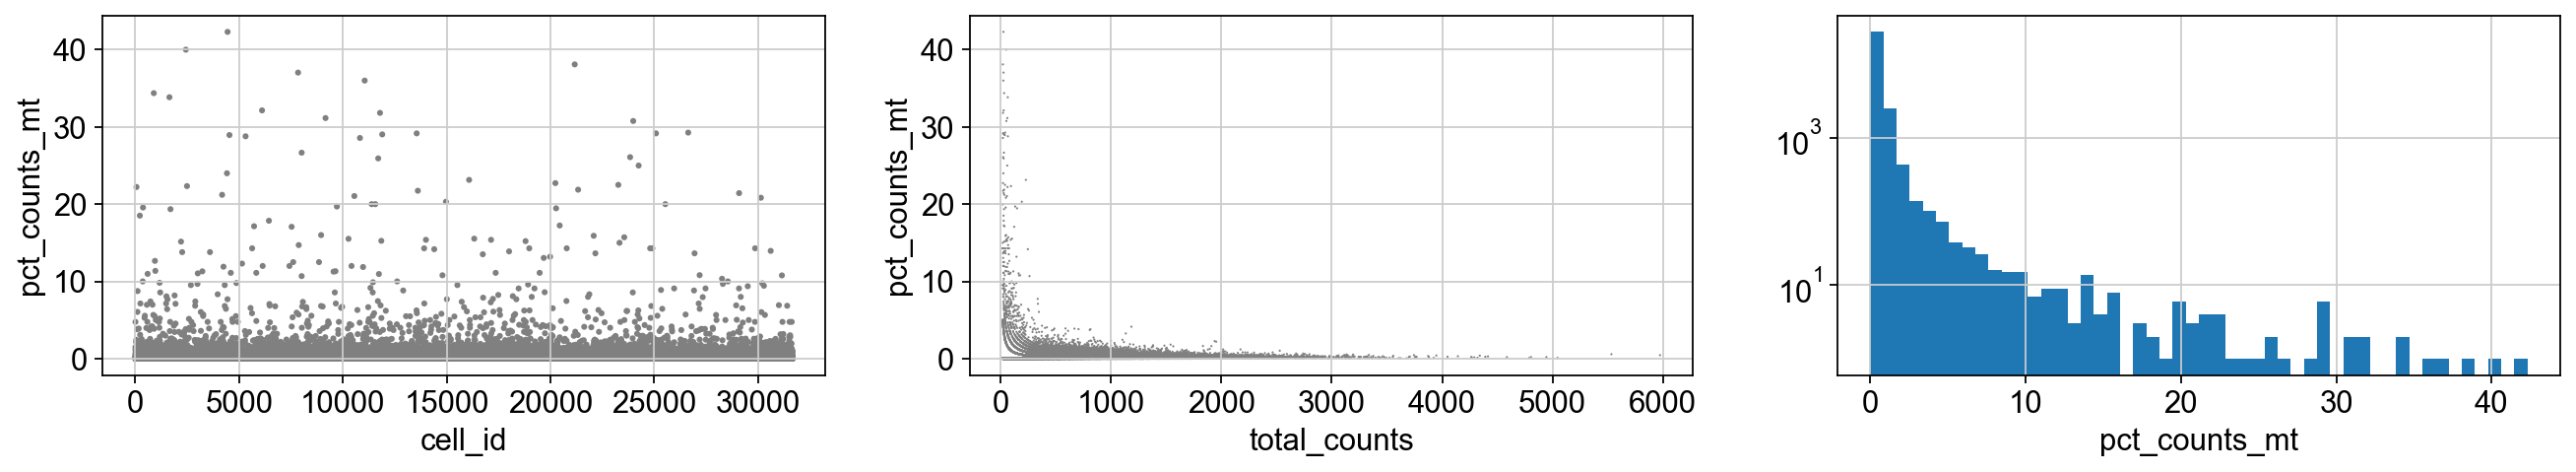

In [9]:
fig, axes = plt.subplots(ncols=3, figsize=(20,3))

_ = sc.pl.scatter(adata, x='cell_id', y='pct_counts_mt', ax=axes[0], size=30, show=False)
_ = sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt', ax=axes[1], show=False)
_ = axes[2].hist(adata.obs['pct_counts_mt'], bins=50, density=False, log=True)
_ = axes[2].set_xlabel("pct_counts_mt")

# Simple Filtering

1. Filter out Bad cells:
   1. too few total mRNAs (bad capture)
   2. too many total mRNAs (doublet?)
   3. too few mRNAs types (low entropy cell)
   4. too much mitocondria (busted cell)  
2. Filter bad genes:
   1. expressed in too few cells (too rare to do anything with it)
   2. keep only highly variables genes


In [10]:
filter_cell = (adata.obs.pct_counts_mt < 5) * \
(adata.obs.n_genes_by_counts > 50) * \
(adata.obs.total_counts > 100) * \
(adata.obs.total_counts < 3000) 
adata = adata[filter_cell, :]

filter_genes = (adata.var.n_cells_by_counts > 10) # * (adata.var.n_cells_by_counts < 25000)
adata = adata[:, filter_genes]

adata

View of AnnData object with n_obs × n_vars = 28983 × 18102
    obs: 'x', 'y', 'cell_type', 'regress_moran_closest', 'cell_id', 'cell_type_codes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_id', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    obsm: 'feature_barlow_closest', 'feature_cell_number_closest', 'feature_composition_closest'

# Compute Neighbourhood composition vector and add to adata

In [11]:
x = adata.obs['x'].to_numpy()
y = adata.obs['y'].to_numpy()
cell_types_codes = adata.obs['cell_type_codes'].values
cell_types_one_hot = torch.nn.functional.one_hot(torch.tensor(cell_types_codes))

from sklearn.neighbors import KDTree

metric_features = numpy.stack((x,y), axis=-1)
kdtree = KDTree(metric_features)
print(metric_features.shape)

for k in (5, 25, 50, 100, 200, 300, 400, 500, 750, 1000, 2000):
    dist, ind = kdtree.query(metric_features, k=k)
  
    print(k, dist.shape, ind.shape)

    # compute the neighborhood composition vector
    ncv_tmp = cell_types_one_hot[ind].sum(dim=-2)
    ncv = ncv_tmp.float() / ncv_tmp.sum(dim=-1, keepdim=True)

    adata.obsm['ncv_'+str(k)] = ncv.cpu().numpy()

(28983, 2)
5 (28983, 5) (28983, 5)
25 (28983, 25) (28983, 25)
50 (28983, 50) (28983, 50)
100 (28983, 100) (28983, 100)
200 (28983, 200) (28983, 200)
300 (28983, 300) (28983, 300)
400 (28983, 400) (28983, 400)
500 (28983, 500) (28983, 500)
750 (28983, 750) (28983, 750)
1000 (28983, 1000) (28983, 1000)
2000 (28983, 2000) (28983, 2000)


In [12]:
adata

AnnData object with n_obs × n_vars = 28983 × 18102
    obs: 'x', 'y', 'cell_type', 'regress_moran_closest', 'cell_id', 'cell_type_codes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_id', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    obsm: 'feature_barlow_closest', 'feature_cell_number_closest', 'feature_composition_closest', 'ncv_5', 'ncv_25', 'ncv_50', 'ncv_100', 'ncv_200', 'ncv_300', 'ncv_400', 'ncv_500', 'ncv_750', 'ncv_1000', 'ncv_2000'

### Subset to highly variable genes

In [13]:
# adata.write_h5ad(filename="adata_before_subset.h5ad")
# adata = anndata.read_h5ad(filename="adata_before_subset.h5ad")
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=200)  # seurat_v3 use raw count data
adata = adata[:, adata.var.highly_variable]

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


/Users/ldalessi/anaconda3/envs/pyro/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)


/Users/ldalessi/anaconda3/envs/pyro/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:182: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


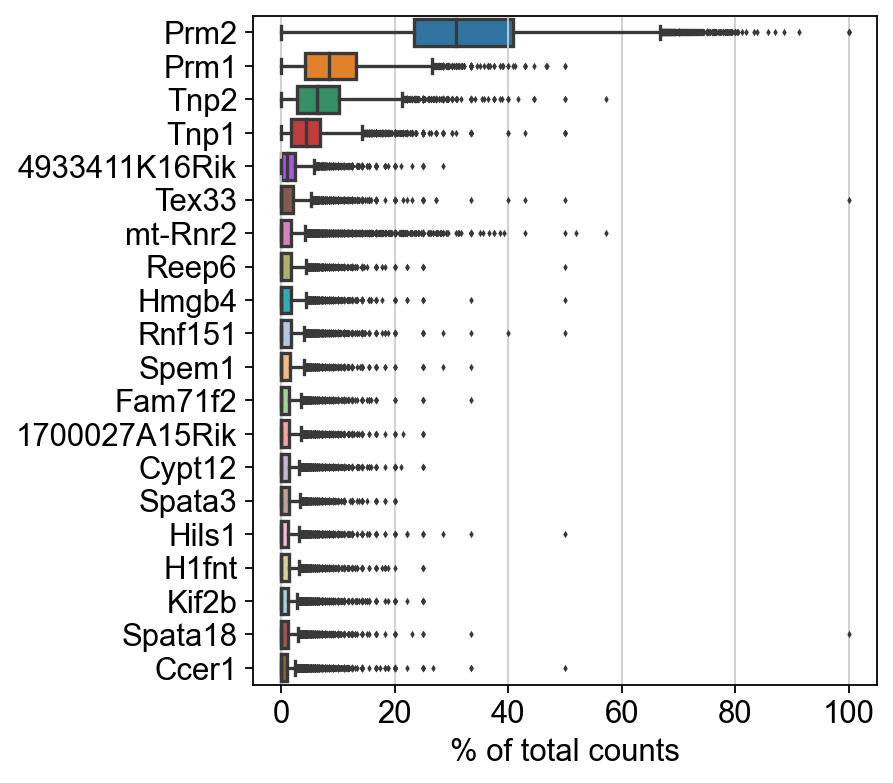

In [14]:
sc.pl.highest_expr_genes(adata, n_top=20, )

Check the count distribution for few genes

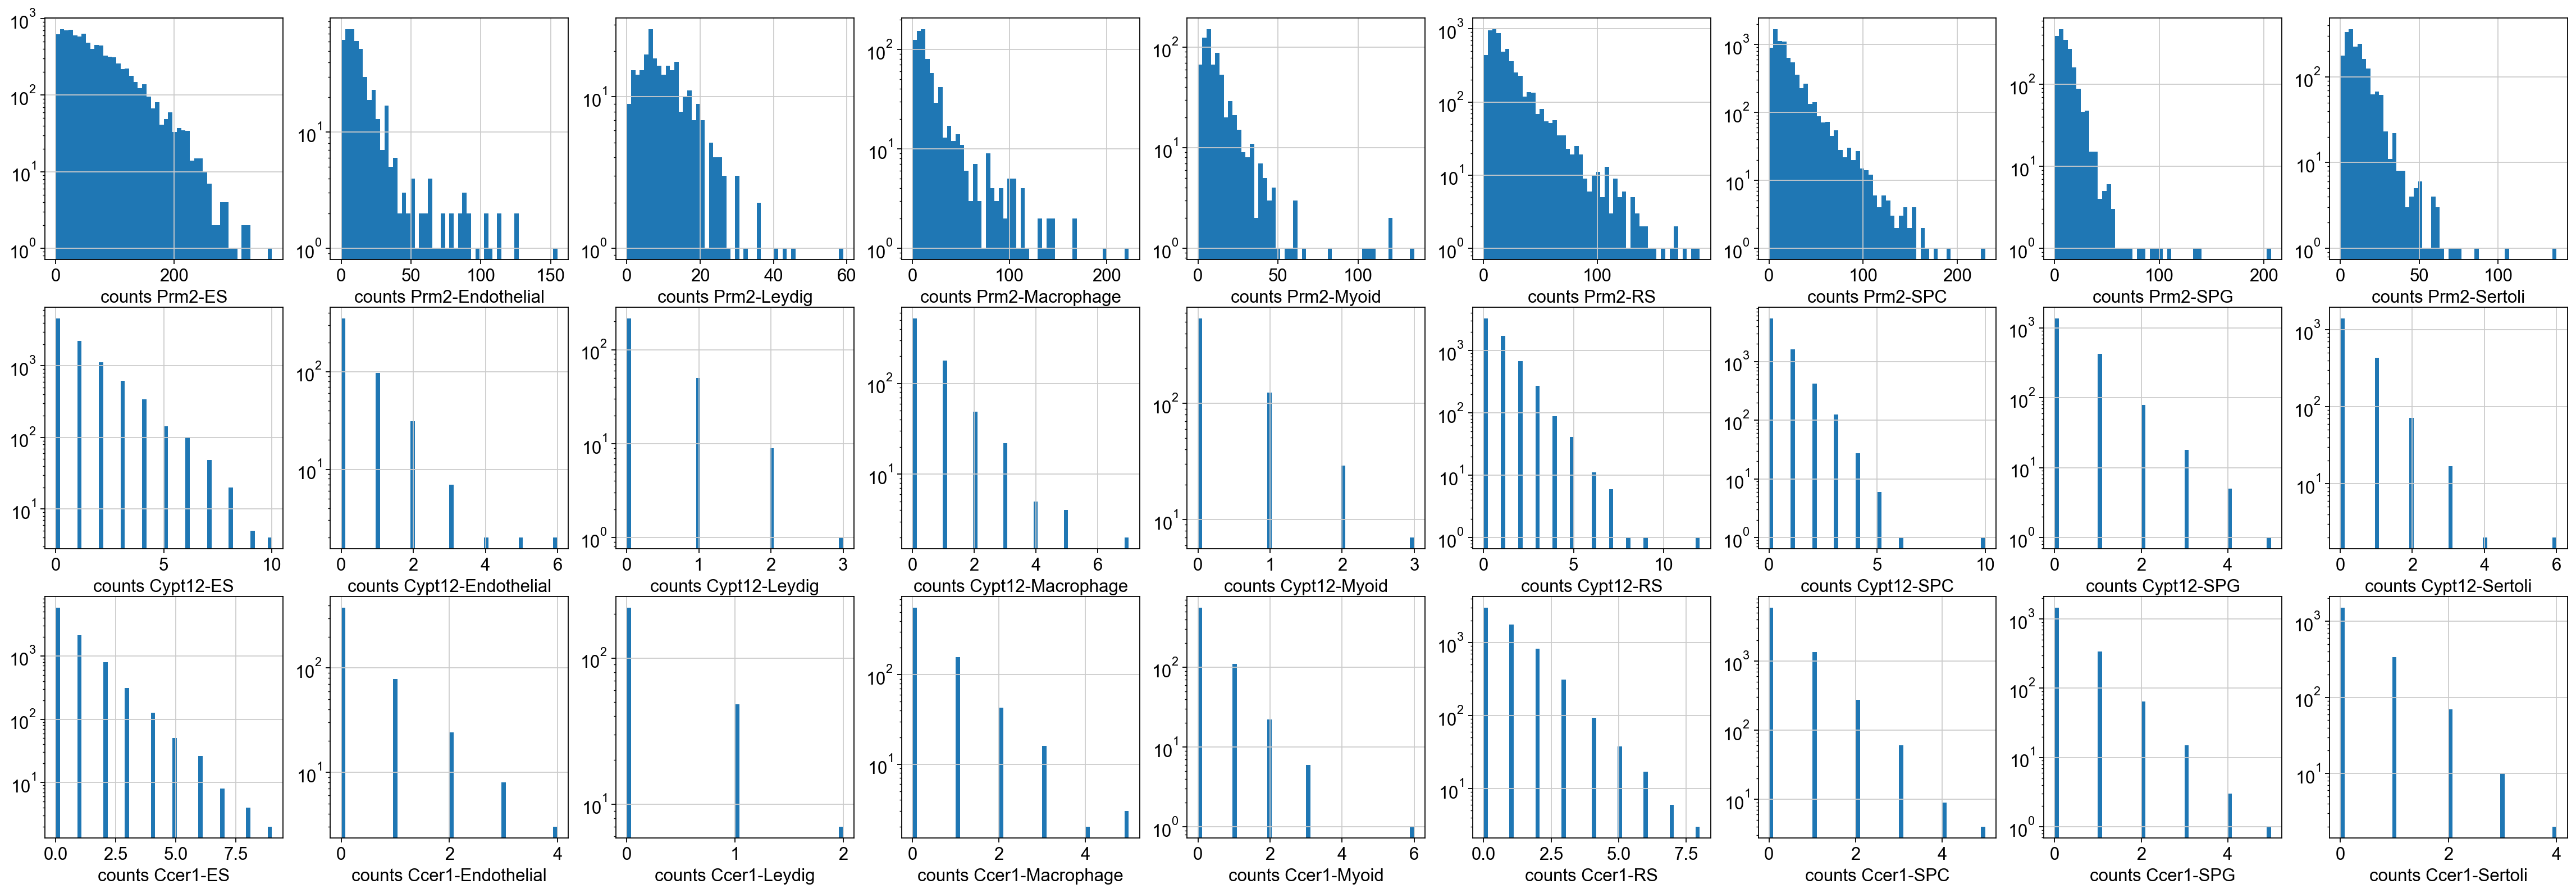

In [15]:
def plot_histo_gene_by_cell_type(input_adata, cell_types, genes):
    ncols = len(cell_types)
    nrows = len(genes)

    fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(4*ncols, 4*nrows))
    for r, g_type in enumerate(genes):
        adata_by_gene = input_adata[:, input_adata.var.index == g_type]
        for c, c_type in enumerate(cell_types):
            adata_tmp = adata_by_gene[adata_by_gene.obs.cell_type == c_type] 
            _ = axes[r,c].hist(adata_tmp.X.toarray(), bins=50, density=False, log=True)
            _ = axes[r,c].set_xlabel("counts {0}-{1}".format(g_type,c_type))
    plt.close()
    return fig

fig = plot_histo_gene_by_cell_type(
    adata, 
    cell_types=numpy.unique(adata.obs['cell_type']), 
    genes=['Prm2', 'Cypt12', 'Ccer1'])
fig

### create the datasets for gene regression

In [24]:
gene_dataset = make_gene_dataset_from_anndata(adata, cell_type_key='cell_type', covariate_key='ncv_300')
gene_dataset

GeneDataset(covariates=tensor([[0.6133, 0.0167, 0.0100,  ..., 0.2500, 0.0200, 0.0500],
        [0.3033, 0.0167, 0.0100,  ..., 0.2233, 0.0867, 0.0833],
        [0.6500, 0.0067, 0.0000,  ..., 0.1400, 0.0467, 0.0400],
        ...,
        [0.1000, 0.0100, 0.0033,  ..., 0.1200, 0.0733, 0.0500],
        [0.2733, 0.0200, 0.0033,  ..., 0.4400, 0.0467, 0.0567],
        [0.4733, 0.0067, 0.0033,  ..., 0.1667, 0.0333, 0.0267]]), cell_type_ids=tensor([0, 5, 0,  ..., 5, 0, 6]), counts=tensor([[1, 0, 1,  ..., 0, 0, 2],
        [0, 1, 0,  ..., 0, 0, 4],
        [1, 2, 0,  ..., 0, 0, 1],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), total_counts=tensor([1936, 1217, 1930,  ...,  190,  851,  134]), k_cell_types=9)

### Generate fake data and visualize

In [25]:
# from tissue_purifier.model_utils.gene_regression import (
#     generate_fake_data, 
#     GeneDataset, 
#     GeneRegression,
#     train_test_val_split,
#     plot_few_gene_hist
# )
# 
# gene_dataset: GeneDataset = generate_fake_data(
#     cells=2000,
#     genes=50,
#     covariates=20,
#     cell_types=9,
#     alpha_scale=0.001,
#     alpha0_loc=-6.0,
#     alpha0_scale=0.5,
#     noise_scale= 0.001)

# counts_ng = gene_dataset.counts
# cell_types_n = gene_dataset.cell_type_ids
# fig = plot_few_gene_hist(cell_types_n, counts_ng[:,:2])
# fig  

# Instantiate the gene_regression model

  Trace Shapes:                  
   Param Sites:                  
          eps_g               200
         alpha0       9     1 200
  Sample Sites:                  
     cells dist                 |
          value         28983   |
       log_prob                 |
cell_types dist                 |
          value             9   |
       log_prob                 |
 covariate dist                 |
          value             9   |
       log_prob                 |
     genes dist                 |
          value           200   |
       log_prob                 |
     alpha dist     9 9   200   |
          value     9 9   200   |
       log_prob     9 9   200   |
    counts dist 28983 1   200   |
          value 28983 1   200   |
       log_prob 28983 1   200   |


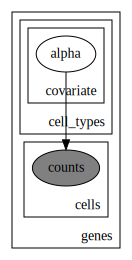

In [26]:
genex = GeneRegression()
genex.render_model(gene_dataset)

### Split Train/Test/Val

In [28]:
sss = train_test_val_split(data=gene_dataset,
                           train_size=0.8,
                           test_size=0.1,
                           val_size=0.1,
                           n_splits=1,
                           stratify=True)

for train_dataset, test_dataset, val_dataset in sss:
    print(train_dataset.counts.shape, test_dataset.counts.shape, val_dataset.counts.shape)

torch.Size([23186, 200]) torch.Size([2899, 200]) torch.Size([2898, 200])


### Train the model for different value of alpha (i.e. L2 regularization on regression coefficients)

In [30]:
genex.configure_optimizer(optimizer_type='adam', lr=5E-3)

alpha_list = [1E-4, 1E-3, 1E-2, 1E-1, 1.0, 10]
ckpt_list = ["./train_alpha_{0}.pt".format(alpha) for alpha in alpha_list]

for alpha, ckpt_file in zip(alpha_list, ckpt_list):
    genex.train(dataset=train_dataset, 
                alpha_scale=alpha, 
                use_covariates=True, 
                eps_g_range=(1.0E-5, 0.5), 
                n_steps=5, 
                print_frequency=100, 
                from_scratch=True)
    genex.save_ckpt(filename=ckpt_file)

[iter 0]  loss: 1390734543.2656
[iter 0]  loss: 1390771845.1797


KeyboardInterrupt: 

### Evaluation

In [ ]:
fig, axes = plt.subplots(nrows=len(ckpt_list), ncols=3, figsize=(16,4*len(ckpt_list)))

mean_log_score_list, mean_deviance_list, params_list = [], [], []
for r, (alpha, ckpt_file) in enumerate(zip(alpha_list, ckpt_list)):
    
    genex.load_ckpt(filename=ckpt_file)
    results, df_logscore, df_deviance = genex.predict(dataset=test_dataset)
    params_list.append(genex.get_params())
    
    
    df1 = df_logscore.groupby(by="cell_type").median()
    df2 = df_deviance.groupby(by="cell_type").median()
    
    _ = genex.show_loss(logy=True, logx=False, ax=axes[r,0])
    _ = seaborn.heatmap(data=df1, cmap="inferno", robust=True, ax=axes[r,1])
    _ = axes[r,1].set_title("log_score")
    _ = seaborn.heatmap(data=df2, cmap="inferno", robust=True, ax =axes[r,2])
    _ = axes[r,2].set_title("deviance")
    
    log_score_mean = df1.mean().mean()
    deviance_score_mean = df2.mean().mean()
    mean_log_score_list.append(log_score_mean)
    mean_deviance_list.append(deviance_score_mean)
    
    print(ckpt_file, alpha, log_score_mean, deviance_score_mean)

show that the gene-specific overdispersion does not depend on the L2 regularization strength 

In [ ]:
x = None
for n, (alpha, params) in enumerate(zip(alpha_list, params_list)):
    eps_g = params["eps_g"]
    alphas = torch.tensor([alpha]*eps_g.shape[0])
    tmp = torch.stack((alphas, eps_g), dim=-1)
    if x is None:
        x = tmp
    else:
        x = torch.cat((x,tmp), dim=0)
        
df = pandas.DataFrame(x.numpy(), columns = ["alpha", "eps_g"])
_ = seaborn.violinplot(x="alpha", y="eps_g", data=df)
# df.head()

show how the aggregate metri change with the regularization strength

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(8,4))
_ = axes[0].plot(alpha_list, mean_log_score_list, 'x')
_ = axes[1].plot(alpha_list, mean_deviance_list, 'x')
_ = axes[0].set_xscale("log")
_ = axes[1].set_xscale("log")
_ = axes[0].set_title("mean log_score (smaller is better)")
_ = axes[1].set_title("mean deviance (smaller is better)")
_ = axes[0].set_xlabel("L2 regularization")
_ = axes[1].set_xlabel("L2 regularization")

### Fix L2 and do a more complete analysis of validation set

train longer if necessary

In [ ]:
# genex.train(dataset=train_dataset, 
#             alpha_scale=alpha_scale, 
#             use_covariates=True, 
#             eps_g_range=(1.0E-5, 0.5), 
#             n_steps=5, 
#             print_frequency=100, 
#             from_scratch=True)
# 
# genex.save_ckpt(filename="./train_final.pt")

or load previously trained model

In [ ]:
ckpt_file = "./train_alpha_0.1.pt"
genex.load_ckpt(filename=ckpt_file)

evaluate on the val_dataset

In [ ]:
results, df_logscore, df_deviance = genex.predict(dataset=val_dataset)
    

# from here
train, cross_validation, test on 
read scoring metrics:
need to add evalute method
    
https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.67.3696&rep=rep1&type=pdf

# FROM HERE. DO THE SUMMARY PLOT

In [ ]:
g = sns.catplot(x="alive", col="cell_type", col_wrap=4,
                data=df_deviance,
                kind="violin")

In [ ]:
nmax = len(log_prob_list)
ncol = 3
nrow = int(numpy.ceil(float(nmax)/ncol))
fig, axes = plt.subplots(ncols=ncol, nrows=nrow, figsize=(4*ncol, 4*nrow))

for n, log_prob in enumerate(log_prob_list):
    r,c = int(n / ncol), n % ncol
    median_kg = compute_median_logprob_per_gene_and_cell_type(cell_types_n, tmp_log_prob)
    mean_log_prob = median_kg.mean()
    _ = seaborn.heatmap(median_kg, cmap="inferno", robust=True, ax=axes[r,c])
    _ = axes[r,c].set_title("mean_log_prob = {0:.3f}".format(mean_log_prob))

In [ ]:
median_kg = compute_median_logprob_per_gene_and_cell_type(cell_types_n, tmp_log_prob)

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20,10))
_ = fig.suptitle("Distance between true counts distribution and estimates")

_ = seaborn.heatmap(median_kg, cmap="inferno", robust=True, ax=axes[0,0])
_ = axes[0,0].set_title("log_prob model 1")

# FROM HERE

### Just for visualization: Plot the predicted_counts vs the real_counts

In [ ]:
fig_A = plot_few_gene_hist(cell_types_n, true_counts_ng[:,:2], predA_counts_ng[:,:2].int(), ncols=3)
fig_B = plot_few_gene_hist(cell_types_n, true_counts_ng[:,:2], predB_counts_ng[:,:2].int(), ncols=3)
fig_C = plot_few_gene_hist(cell_types_n, true_counts_ng[:,:2], predC_counts_ng[:,:2].int(), ncols=3)

## Quantify the variance 
1. at the level of distributions
2. at the level of single predictions

### at the level of distributions

In [ ]:
true_dist_kgi = compute_per_cell_type_distributions(cell_types_n, true_counts_ng)
predA_dist_kgi = compute_per_cell_type_distributions(cell_types_n, predA_counts_ng)
predB_dist_kgi = compute_per_cell_type_distributions(cell_types_n, predB_counts_ng)
predC_dist_kgi = compute_per_cell_type_distributions(cell_types_n, predC_counts_ng)

In [ ]:
L1_norm_A = L1_between_distributions(true_dist_kgi, predA_dist_kgi, normalize=True)
L1_norm_B = L1_between_distributions(true_dist_kgi, predB_dist_kgi, normalize=True)
L1_norm_C = L1_between_distributions(true_dist_kgi, predC_dist_kgi, normalize=True)

EMD_norm_A = EMD_between_distributions(true_dist_kgi, predA_dist_kgi, normalize=True)
EMD_norm_B = EMD_between_distributions(true_dist_kgi, predB_dist_kgi, normalize=True)
EMD_norm_C = EMD_between_distributions(true_dist_kgi, predC_dist_kgi, normalize=True)

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20,10))
_ = fig.suptitle("Distance between true counts distribution and estimates")

_ = seaborn.heatmap(L1_norm_A, cmap="inferno", robust=True, ax=axes[0,0])
_ = seaborn.heatmap(L1_norm_B, cmap="inferno", robust=True, ax=axes[0,1])
_ = seaborn.heatmap(L1_norm_C, cmap="inferno", robust=True, ax=axes[0,2])
_ = axes[0,0].set_title("L1 wrt MLE estimates")
_ = axes[0,1].set_title("L1 wrt MAP estimates")
_ = axes[0,2].set_title("L1 wrt MAP estimates, alpha0 no prior")

_ = seaborn.heatmap(EMD_norm_A, cmap="inferno", robust=True, ax=axes[1,0])
_ = seaborn.heatmap(EMD_norm_B, cmap="inferno", robust=True, ax=axes[1,1])
_ = seaborn.heatmap(EMD_norm_C, cmap="inferno", robust=True, ax=axes[1,2])
_ = axes[1,0].set_title("EMD wrt MLE estimates")
_ = axes[1,1].set_title("EMD wrt MAP estimates")
_ = axes[1,2].set_title("EMD wrt MAP estimates, alpha0 no prior")

In [ ]:
print(L1_norm_A.median(), L1_norm_B.median(), L1_norm_C.median())
print(EMD_norm_A.median(), EMD_norm_B.median(), EMD_norm_C.median())

## At the level of single predictions

In [ ]:
from tissue_purifier.misc_utils.validation import (
    create_null_distribution,
    create_heldout_distribution
)

null_dist = create_null_distribution(
    cell_types_n=cell_types_n, 
    counts_ng=counts_ng[:,:10], 
    similarity_measure="L1",
    boundaries=torch.linspace(start=0, end=30, steps=31),
)   


heldout_dist = create_heldout_distribution(
    cell_types_n=cell_types_n, 
    true_counts_ng=counts_ng[:,:10], 
    pred_counts_ng=counts_ng[:,:10]+1,
    similarity_measure="L1",
    boundaries=torch.linspace(start=0, end=30, steps=31),
)   

### test the procedure by creating two fake distributions

In [ ]:
null_dist = create_null_distribution(
    cell_types_n=cell_types_n[-1000:], 
    counts_ng=counts_ng[-1000:,:10], 
    similarity_measure="L1",
    boundaries=torch.linspace(start=0, end=30, steps=31),
)     

heldout_dist = create_null_distribution(
    cell_types_n=cell_types_n[:1000], 
    counts_ng=counts_ng[:1000,:10], 
    similarity_measure="L1",
    boundaries=torch.linspace(start=0, end=30, steps=31),
)     

In [ ]:
gene_id = 1

x_null = null_dist["cell_type_0"][gene_id,:] / numpy.sum(null_dist["cell_type_0"][gene_id,:], axis=-1, keepdims=True)
x_heldout = heldout_dist["cell_type_0"][gene_id,:] / numpy.sum(heldout_dist["cell_type_0"][gene_id,:], axis=-1, keepdims=True)

barWidth=0.4
plt.bar(null_dist["boundaries"], 
        x_null, 
        width = barWidth,
       label="null")
plt.bar(heldout_dist["boundaries"]+barWidth, 
        x_heldout,
        width = barWidth,
       label="Heldout")
_ = plt.xlim([-1,20])
_ = plt.legend()
_ = plt.title("Distribution of Chi = |counts - counts|")

In [ ]:
gene_id = 6

x_null = null_dist["cell_type_0"][gene_id,:] / numpy.sum(null_dist["cell_type_0"][gene_id,:], axis=-1, keepdims=True)
x_heldout = heldout_dist["cell_type_0"][gene_id,:] / numpy.sum(heldout_dist["cell_type_0"][gene_id,:], axis=-1, keepdims=True)

barWidth=0.4
plt.bar(null_dist["boundaries"], 
        x_null, 
        width = barWidth,
       label="null")
plt.bar(heldout_dist["boundaries"]+barWidth, 
        x_heldout,
        width = barWidth,
       label="Heldout")
_ = plt.xlim([-1,20])
_ = plt.legend()
_ = plt.title("Distribution of Chi = |counts - counts|")

### Two-sample Kolmogorov–Smirnov test
I am asking the question if the two distribution are the same


In [ ]:
from scipy.interpolate import interp1d
from typing import NamedTuple, Union
    
class KS_test(NamedTuple):
    """ 
    Result of the KS test between two empirical distributions.
    """
    x: numpy.ndarray
    f1: numpy.ndarray
    f2: numpy.ndarray
    gap: numpy.ndarray
    ks: Union[float, numpy.ndarray]
    n1: Union[int, numpy.array]
    n2: Union[int, numpy.array]
        

def compute_pvalue_from_ks(ks_test: KS_test) -> numpy.ndarray:
    """
    Compute the p-value using the asymptotic formula 
    see. https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test
    """
    n1 = ks_test.n1
    n2 = ks_test.n2
    D = ks_test.ks
    tmp = (2 * D * D * n1 * n2) / (n1 + n2)
    p = 2 * numpy.exp(-tmp)
    return p

    
def compute_KS_test(x1, histo1, x2, histo2) -> KS_test:
    
    # (empirical) cumulative distribution and size of sample
    F1_tmp = histo1.cumsum(axis=-1) # shape (genes, bins)
    n1 = F1_tmp[...,-1:]            # shape (genes, 1)
    F1 = F1_tmp / n1                # shape (genes, bins)
    
    # (empirical) cumulative distribution and size of sample
    F2_tmp = histo2.cumsum(axis=-1) 
    n2 = F2_tmp[..., -1:]
    F2 = F2_tmp / n2
    
    # Interpolate sample 1 on the spacing of sample 2 
    f_interp = interp1d(x1, F1, axis=-1, fill_value=(0.0, 1.0))
    F1_new = f_interp(x2)
    
    # Comute the maximum gap between empirical cumulative distributions
    gap = numpy.abs(F1_new - F2)
    ks = numpy.max(gap, axis=-1, keepdims=True)
    
    return KS_test(x=x2, f1=F1_new, f2=F2, n1=n1, n2=n2, gap=gap, ks=ks)


key_cell_types = []
for key in null_dist.keys():
    if key.startswith("cell_type_"):
        key_cell_types.append(key)
    

#df = pandas.DataFrame()
for k in key_cell_types:        
    
    ks_test_tmp = compute_KS_test(
        x1=null_dist["boundaries"], 
        histo1=null_dist["cell_type_0"], 
        x2=heldout_dist["boundaries"], 
        histo2=heldout_dist["cell_type_0"])
    
    p_values_tmp = compute_pvalue_from_ks(ks_test_tmp)
    
    
    
#    dfdf = pd.DataFrame(columns=["firstname", "lastname"])
#df = df.append({
#     "firstname": "John",
#     "lastname":  "Johny"
#      }, ignore_index=True)
    
    dict_tmp = {'ks' : ks_test_tmp.ks, 'p_value': p_values_tmp, 'cell_type': [k]*len(p_values_tmp)}

In [ ]:
ncol = 4
nmax = len(ks_test.ks)
nrow = int(numpy.ceil(float(nmax) / ncol))

fig, axes = plt.subplots(ncols=ncol, nrows=nrow, figsize=(4*ncol, 4*nrow))
for n in range(nmax):
    r,c = n // ncol, n % ncol
    axes[r,c].plot(ks_test.x, ks_test.f1[n,:])
    axes[r,c].plot(ks_test.x, ks_test.f2[n,:])
    axes[r,c].plot(ks_test.x, ks_test.gap[n,:])
    axes[r,c].set_xlim([0,20])
    axes[r,c].set_title("ks={0:.3} -> pvalue={1:.3}".format(ks_test.ks[n].item(), p_values[n].item()))